In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas
import sys
import scipy
sys.path.append('/Users/ruby/EoR/pyuvdata')
from pyuvdata import UVData

In [2]:
# Load data:
model_path = '/Users/ruby/EoR/calibration_testing_May2020/fhd_rlb_random_array_Barry_effect_sim_May2018'
model_use_model = True
data_path = '/Users/ruby/EoR/calibration_testing_May2020/fhd_rlb_random_array_sim_reference_May2018'
data_use_model = True
obsid='random1_array_sim'
pol='XX'

model_filelist = ['{}/{}'.format(model_path, file) for file in [
    'vis_data/{}_vis_{}.sav'.format(obsid, pol),
    'vis_data/{}_vis_model_{}.sav'.format(obsid, pol),
    'vis_data/{}_flags.sav'.format(obsid),
    'metadata/{}_params.sav'.format(obsid),
    'metadata/{}_settings.txt'.format(obsid)
]]
data_filelist = ['{}/{}'.format(data_path, file) for file in [
    'vis_data/{}_vis_{}.sav'.format(obsid, pol),
    'vis_data/{}_vis_model_{}.sav'.format(obsid, pol),
    'vis_data/{}_flags.sav'.format(obsid),
    'metadata/{}_params.sav'.format(obsid),
    'metadata/{}_settings.txt'.format(obsid)
]]

model = UVData()
print('Reading model...')
model.read(
    model_filelist, file_type='fhd', use_model=model_use_model, 
    run_check=False, check_extra=False, run_check_acceptability=False
)
data = UVData()
print('Reading data...')
data.read(
    data_filelist, file_type='fhd', use_model=data_use_model,
    run_check=False, check_extra=False, run_check_acceptability=False
)
print('Done.')

Reading model...


No layout file included in file list, antenna_postions will not be defined.


Reading data...


No layout file included in file list, antenna_postions will not be defined.


Done.


In [3]:
# For testing, use one time only
# Select function requires dummy data in the antenna positions
data.antenna_positions = np.zeros((data.Nants_telescope, 3))
model.antenna_positions = np.zeros((model.Nants_telescope, 3))
# Select time
use_time = data.time_array[200000]
data.select(times=use_time)
model.select(times=use_time)

In [7]:
print(data.Nants_data)
print(data.Nbls)
print(127*127/2)

127
8128
8001.0


In [71]:
# Reformat data:
data_times = np.unique(data.time_array)
data_antennas = np.unique(np.append(data.ant_1_array, data.ant_2_array))

# Data has shape (Nblts, Nspws, Nfreqs, Npols)
# Reformat data array to have shape (Nants, Nants, Ntimes, Nfreqs)
print 'Reformatting arrays...'
data_vis_array = np.full(
    (data.Nants_data, data.Nants_data, data.Ntimes, data.Nfreqs),
    np.nan, dtype=complex
)
model_vis_array = np.full(
    (data.Nants_data, data.Nants_data, data.Ntimes, data.Nfreqs),
    np.nan, dtype=complex
)
bl_lengths = np.full((data.Nants_data, data.Nants_data), np.nan)
for ind in range(data.Nblts):
    ant1 = np.where((data_antennas == data.ant_1_array[ind]))[0][0]
    ant2 = np.where((data_antennas == data.ant_2_array[ind]))[0][0]
    time = np.where((data_times == data.time_array[ind]))[0][0]
    data_vis_array[ant1, ant2, time, :] = data.data_array[ind, 0, :, 0]
    data_vis_array[ant2, ant1, time, :] = np.conj(
        data.data_array[ind, 0, :, 0]
    )
    if np.isnan(bl_lengths[ant1, ant2]): #UVWs are the same at all times
        bl_len = np.sqrt(np.sum(np.square(data.uvw_array[ind, :])))
        bl_lengths[ant1, ant2] = bl_len
        bl_lengths[ant2, ant1] = bl_len
for ind in range(model.Nblts):
    ant1 = np.where((data_antennas == model.ant_1_array[ind]))[0][0]
    ant2 = np.where((data_antennas == model.ant_2_array[ind]))[0][0]
    time = np.where((data_times == model.time_array[ind]))[0][0]
    model_vis_array[ant1, ant2, time, :] = model.data_array[ind, 0, :, 0]
    model_vis_array[ant2, ant1, time, :] = np.conj(
        model.data_array[ind, 0, :, 0]
    )
print 'Done.'
freq_array = data.freq_array[0,:]

# Initialize weights:
vis_weights_array = np.full(
    (data.Nants_data, data.Nants_data, data.Ntimes, data.Nfreqs),
    1., dtype=float
)
data_nans = np.where(np.isnan(data_vis_array))
if len(data_nans[0]) > 0:
    vis_weights_array[data_nans[[0, 1, 2, 4]]] = 0.
model_nans = np.where(np.isnan(model_vis_array))
if len(model_nans[0]) > 0:
    vis_weights_array[model_nans[[0, 1, 2, 4]]] = 0.

Reformatting arrays...
Done.


In [82]:
print bl_lengths<-1.
print np.where(bl_lengths<1.)[0]

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126]


In [44]:
# Core calibration routine:
def calibration_routine(
    data_vis_array, model_vis_array, vis_weights_array, delay_calibrate=False,
    convergence_threshold=1, max_iter=1000, step_size=5e-6, use_autos=False,
    gains_init=None, min_cal_baseline=None, max_cal_baseline=None,
    max_leakage_mode=None
):

    Nants, Ntimes, Nfreqs = data_vis_array.shape[1:4]

    # Initialize gains to 1
    if gains_init is None:
        gains = np.full((Nants, Nfreqs), 1., dtype=complex)
    else:
        gains = gains_init

    if not use_autos:  # autocalibration is currently not supported
        for ind in range(Nants):
            vis_weights_array[ind, ind, :] = 0.
    else:
        print 'WARNING: Autocalibration is not supported.'
        
    if min_cal_baseline is not None:
        locs = np.where(bl_lengths < min_cal_baseline)
        for ind in range(len(locs[0])):
            if locs[0, ind] != locs[1, ind]:  # autos must be excluded with use_autos keyword
                vis_weights_array[locs[0, ind], locs[1, ind], :] = 0
    if max_cal_baseline is not None:
        locs = np.where(bl_lengths > max_cal_baseline)
        for ind in range(len(locs[0])):
            vis_weights_array[locs[0, ind], locs[1, ind], :] = 0

    if delay_calibrate:
        data_vis_array = np.fft.fftshift(
            np.fft.fft(data_vis_array, axis=3),
        axes=3)
        model_vis_array = np.fft.fftshift(
            np.fft.fft(model_vis_array, axis=3),
        axes=3)

    for mode in range(Nfreqs):
        gains_ant1_mat = np.repeat(np.repeat(
            gains[:, mode, np.newaxis], Nants, axis=1
            )[:, :, np.newaxis], Ntimes, axis=2
        )
        gains_ant2_mat = np.transpose(gains_ant1_mat, axes=[1, 0, 2])
        chi_squared = np.sum(vis_weights_array[:, :, :, mode] * np.abs(
            data_vis_array[:, :, :, mode]
            - gains_ant1_mat * np.conj(gains_ant2_mat)
            * model_vis_array[:, :, :, mode]
        )**2.)
        print "Initial X-squared for mode {}: {}".format(mode+1, chi_squared)

        # Initialize convergence parameter
        convergence = convergence_threshold+1
        iter = 0  # initialize iter parameter
        while iter <= max_iter and convergence >= convergence_threshold:

            # Calculate the gradient of the real part of the gains
            gain_grad_real = 4*np.sum(vis_weights_array[:, :, :, mode]*(
                np.real(gains_ant1_mat)
                * np.abs(gains_ant2_mat)**2.
                * np.abs(model_vis_array[:, :, :, mode])**2.
                - np.real(
                    np.conj(data_vis_array[:, :, :, mode])
                    * np.conj(gains_ant2_mat)
                    * model_vis_array[:, :, :, mode]
                )
                ), axis=(1, 2)
            )

            # Calculate the gradient of the imaginary part of the gains
            gain_grad_imag = 4*np.sum(vis_weights_array[:, :, :, mode]*(
                np.imag(gains_ant1_mat)
                * np.abs(gains_ant2_mat)**2.
                * np.abs(model_vis_array[:, :, :, mode])**2.
                + np.imag(
                    np.conj(data_vis_array[:, :, :, mode])
                    * np.conj(gains_ant2_mat)
                    * model_vis_array[:, :, :, mode]
                )
                ), axis=(1, 2)
            )

            convergence = np.sqrt(
                np.sum(gain_grad_real**2.) + np.sum(gain_grad_imag**2.)
            )/Nants

            # Update gains
            gains[:, mode] -= (
                (gain_grad_real + 1j * gain_grad_imag)
                / convergence * step_size
            )
            gains_ant1_mat = np.repeat(np.repeat(
                gains[:, mode, np.newaxis], Nants, axis=1
                )[:, :, np.newaxis], Ntimes, axis=2
            )
            gains_ant2_mat = np.transpose(gains_ant1_mat, axes=[1, 0, 2])
            new_chi_squared = np.sum(vis_weights_array[:, :, :, mode] * np.abs(
                data_vis_array[:, :, :, mode]
                - gains_ant1_mat * np.conj(gains_ant2_mat)
                * model_vis_array[:, :, :, mode]
            )**2.)
            chi_squared = new_chi_squared
            iter += 1
    return gains

def apply_calibration(data_vis_array, gains, delay_calibrate=False):

    Nants, Ntimes, Nfreqs = data_vis_array.shape[1:4]
    gains_ant1_mat = np.repeat(np.repeat(
        gains[:, np.newaxis, :], Nants, axis=1
        )[:, :, np.newaxis, :], Ntimes, axis=2
    )
    gains_ant2_mat = np.transpose(gains_ant1_mat, axes=[1, 0, 2, 3])
    if delay_calibrate:
        data_vis_array = np.fft.fftshift(
            np.fft.fft(data_vis_array, axis=3),
        axes=3)
    data_vis_array = data_vis_array/(gains_ant1_mat*np.conj(gains_ant2_mat))
    if delay_calibrate:
        data_vis_array = np.fft.ifft(
            np.fft.ifftshift(data_vis_array, axes=3),
        axis=3)
    return data_vis_array

In [5]:
# Run calibration
gains = calibration_routine(data_vis_array, model_vis_array, vis_weights_array)

Initial X-squared for mode 1: 93164.059093
Initial X-squared for mode 2: 92940.5954326
Initial X-squared for mode 3: 92722.6878296
Initial X-squared for mode 4: 92509.858848
Initial X-squared for mode 5: 92301.8532737
Initial X-squared for mode 6: 92098.2006548
Initial X-squared for mode 7: 91898.6433541
Initial X-squared for mode 8: 91702.6613956
Initial X-squared for mode 9: 91510.160346
Initial X-squared for mode 10: 91320.8438821
Initial X-squared for mode 11: 91134.4632457
Initial X-squared for mode 12: 90950.8911343
Initial X-squared for mode 13: 90769.9115961
Initial X-squared for mode 14: 90591.4356697
Initial X-squared for mode 15: 90415.1993168
Initial X-squared for mode 16: 90241.1296697
Initial X-squared for mode 17: 90068.9828914
Initial X-squared for mode 18: 89898.4452124
Initial X-squared for mode 19: 89729.3196394
Initial X-squared for mode 20: 89561.1477755
Initial X-squared for mode 21: 89393.5665462
Initial X-squared for mode 22: 89225.9608915
Initial X-squared for 

Initial X-squared for mode 182: 81244.1721611
Initial X-squared for mode 183: 81195.2686064
Initial X-squared for mode 184: 81147.7764841
Initial X-squared for mode 185: 81101.9390813
Initial X-squared for mode 186: 81058.0594529
Initial X-squared for mode 187: 81016.436353
Initial X-squared for mode 188: 80977.4514624
Initial X-squared for mode 189: 80941.5485677
Initial X-squared for mode 190: 80909.1487414
Initial X-squared for mode 191: 80880.7741908
Initial X-squared for mode 192: 80856.8665938
Initial X-squared for mode 193: 80837.9282084
Initial X-squared for mode 194: 80824.3652487
Initial X-squared for mode 195: 80816.5778332
Initial X-squared for mode 196: 80814.8203098
Initial X-squared for mode 197: 80819.3375591
Initial X-squared for mode 198: 80830.1542483
Initial X-squared for mode 199: 80847.258912
Initial X-squared for mode 200: 80870.4362448
Initial X-squared for mode 201: 80899.3220762
Initial X-squared for mode 202: 80933.4562314
Initial X-squared for mode 203: 8097

Initial X-squared for mode 361: 81800.2516892
Initial X-squared for mode 362: 81852.4845772
Initial X-squared for mode 363: 81907.2851291
Initial X-squared for mode 364: 81964.2033462
Initial X-squared for mode 365: 82022.7918388
Initial X-squared for mode 366: 82082.1842364
Initial X-squared for mode 367: 82142.0867128
Initial X-squared for mode 368: 82202.2930701
Initial X-squared for mode 369: 82262.227759
Initial X-squared for mode 370: 82321.8336187
Initial X-squared for mode 371: 82381.0494363
Initial X-squared for mode 372: 82439.9302336
Initial X-squared for mode 373: 82498.7377188
Initial X-squared for mode 374: 82557.3416745
Initial X-squared for mode 375: 82616.0918985
Initial X-squared for mode 376: 82675.5061167
Initial X-squared for mode 377: 82735.5066393
Initial X-squared for mode 378: 82796.5733758
Initial X-squared for mode 379: 82859.1578264
Initial X-squared for mode 380: 82923.2541721
Initial X-squared for mode 381: 82989.2258885
Initial X-squared for mode 382: 830

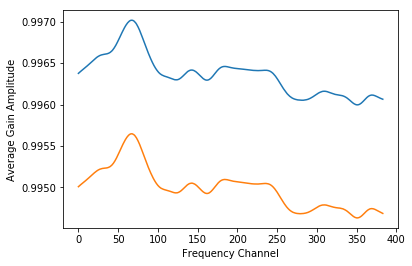

In [6]:
# Compare to saved FHD results
gains_avg_amp = np.mean(np.abs(gains), axis=0)

cal = scipy.io.readsav(
    '/Users/ruby/EoR/calibration_testing_Sept2019/fhd_rlb_random_array_Barry_effect_sim_May2018/calibration/random1_array_sim_cal.sav'
)
fhd_gains_avg_amp = np.mean(np.abs(cal['cal']['gain'][0][0]), axis=0)

plt.plot(gains_avg_amp)
plt.plot(fhd_gains_avg_amp)
plt.xlabel('Frequency Channel')
plt.ylabel('Average Gain Amplitude')
plt.show()

In [28]:
#Apply calibration solutions to a subset of the data
data_vis_array_limited = data_vis_array[0:10,0:10,:,:]
gains_limited = gains[0:10,:]
data_calibrated = apply_calibration(data_vis_array_limited, gains_limited)

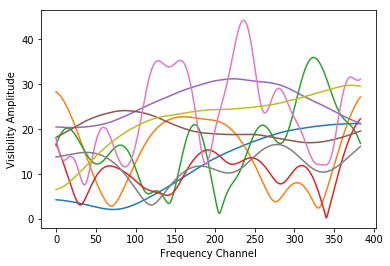

In [39]:
for ant in range(1,10):
    plt.plot(np.abs(data_calibrated[0,ant,0,:]))
plt.xlabel('Frequency Channel')
plt.ylabel('Visibility Amplitude')
plt.show()

In [42]:
# Run delay calibration
delay_gains = calibration_routine(data_vis_array, model_vis_array, vis_weights_array, delay_calibrate=True)

Initial X-squared for mode 1: 42478.6214305
Initial X-squared for mode 2: 42481.4594753
Initial X-squared for mode 3: 42490.0258599
Initial X-squared for mode 4: 42504.2783432
Initial X-squared for mode 5: 42524.1994992
Initial X-squared for mode 6: 42549.8322456
Initial X-squared for mode 7: 42581.2097442
Initial X-squared for mode 8: 42618.3336389
Initial X-squared for mode 9: 42661.2052594
Initial X-squared for mode 10: 42709.8669439
Initial X-squared for mode 11: 42764.3199538
Initial X-squared for mode 12: 42824.6388786
Initial X-squared for mode 13: 42890.8616256
Initial X-squared for mode 14: 42962.9798989
Initial X-squared for mode 15: 43041.0829236
Initial X-squared for mode 16: 43125.1452755
Initial X-squared for mode 17: 43215.241399
Initial X-squared for mode 18: 43311.403584
Initial X-squared for mode 19: 43413.7292132
Initial X-squared for mode 20: 43522.2621698
Initial X-squared for mode 21: 43637.0581151
Initial X-squared for mode 22: 43758.1793813
Initial X-squared for

Initial X-squared for mode 182: 6089529.22656
Initial X-squared for mode 183: 8798311.1611
Initial X-squared for mode 184: 14459613.4227
Initial X-squared for mode 185: 21852822.8489
Initial X-squared for mode 186: 35239533.4695
Initial X-squared for mode 187: 54425704.8561
Initial X-squared for mode 188: 86539780.4346
Initial X-squared for mode 189: 165377784.394
Initial X-squared for mode 190: 378224946.447
Initial X-squared for mode 191: 948897857.493
Initial X-squared for mode 192: 2248167088.33
Initial X-squared for mode 193: 4129746478.19
Initial X-squared for mode 194: 2248167088.33
Initial X-squared for mode 195: 948897857.493
Initial X-squared for mode 196: 378224946.447
Initial X-squared for mode 197: 165377784.394
Initial X-squared for mode 198: 86539780.4346
Initial X-squared for mode 199: 54425704.8561
Initial X-squared for mode 200: 35239533.4695
Initial X-squared for mode 201: 21852822.8489
Initial X-squared for mode 202: 14459613.4227
Initial X-squared for mode 203: 879

Initial X-squared for mode 361: 44160.1666903
Initial X-squared for mode 362: 44019.6870719
Initial X-squared for mode 363: 43885.7091751
Initial X-squared for mode 364: 43758.1793813
Initial X-squared for mode 365: 43637.0581151
Initial X-squared for mode 366: 43522.2621698
Initial X-squared for mode 367: 43413.7292132
Initial X-squared for mode 368: 43311.403584
Initial X-squared for mode 369: 43215.241399
Initial X-squared for mode 370: 43125.1452755
Initial X-squared for mode 371: 43041.0829236
Initial X-squared for mode 372: 42962.9798989
Initial X-squared for mode 373: 42890.8616256
Initial X-squared for mode 374: 42824.6388786
Initial X-squared for mode 375: 42764.3199538
Initial X-squared for mode 376: 42709.8669439
Initial X-squared for mode 377: 42661.2052594
Initial X-squared for mode 378: 42618.3336389
Initial X-squared for mode 379: 42581.2097442
Initial X-squared for mode 380: 42549.8322456
Initial X-squared for mode 381: 42524.1994992
Initial X-squared for mode 382: 4250

In [45]:
#Apply delay calibration solutions to a subset of the data
data_vis_array_limited = data_vis_array[0:10,0:10,:,:]
gains_limited = delay_gains[0:10,:]
data_delay_calibrated = apply_calibration(data_vis_array_limited, gains_limited, delay_calibrate=True)

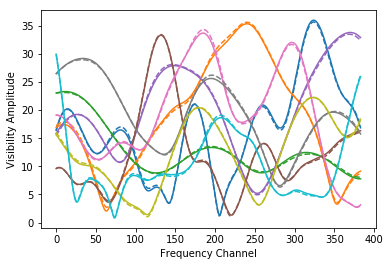

In [62]:
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
ant1 = 3
for ant2 in range(10):
    if ant1 != ant2:
        plt.plot(np.abs(data_calibrated[ant1,ant2,0,:]), color=colors[ant2])
        plt.plot(np.abs(data_delay_calibrated[ant1,ant2,0,:]), color=colors[ant2], linestyle='dashed')
plt.xlabel('Frequency Channel')
plt.ylabel('Visibility Amplitude')
plt.show()